# Анализ пользовательского поведения в мобильном приложении

Необходимо разобраться, как ведут себя пользователи мобильного приложения, который продаёт продукты питания.
Для этого необходимо изучить воронку продаж и проанализировать как пользователи доходят до покупки, а также оценить результаты A/A/B-тестирования. 

Для проведения анализа у нас есть запись логов. Каждая запись в логе — это действие пользователя, или событие.
* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Цель -  проанализировать пользовательское поведение в приложении и принять решение о необходимости смене шрифтов.


## Изучение общей информации и предобработка данных

Импортируем библиотеки, с которыми будем работать.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from plotly import graph_objects as go
import plotly.express as px
import re
import requests
import datetime
from datetime import datetime as dt
import math as mth
from scipy import stats as st

Прочитаем файл с данными по заведениям общественного питания в Москве и сохраним его в переменной **data**.

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv')
data.head()

,EventName\tDeviceIDHash\tEventTimestamp\tExpId
0,MainScreenAppear\t4575588528974610257\t1564029...
1,MainScreenAppear\t7416695313311560658\t1564053...
2,PaymentScreenSuccessful\t3518123091307005509\t...
3,CartScreenAppear\t3518123091307005509\t1564054...
4,PaymentScreenSuccessful\t6217807653094995999\t...


Как мы видим данные склеились в одну строку. В параметрах функции read_csv() зададим sep='\t', чтобы указать какими символами разделять колонки.

In [3]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Заменим названия столбцов на удобные, с которыми будет проще работать в дальнейшем.

In [4]:
data.columns=['event_name', 'user_id', 'event_timestamp', 'exp_id']
data.head()

,event_name,user_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Изучим общую информацию по датасету.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   user_id          244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Всего у нас 244 126 наблюдений, пропущенных значений нет.  Данные в столбце о времени события (event_timestamp) представлены в формате целочисленных значений. Приведем эти значения к типу дата.

In [6]:
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'], unit='s')
data.head()

,event_name,user_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


Также добавим отдельный столбец *date*, где будет только дата события.

In [7]:
data['date'] = data['event_timestamp'].dt.date
data['date'] = pd.to_datetime(data['date'])
data.head()

,event_name,user_id,event_timestamp,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Проверим датасет на наличие дубликатов.

In [8]:
data.duplicated().sum()

413

В сравнении с общим числом записей количество дубликатов совсем небольшое, всего 0.17%. Удалим задвоенные записи из нашего датасета.

In [9]:
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   user_id          243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
 4   date             243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.2+ MB


**Вывод**

Для анализа у нас есть запись логов, которую мы сохранили в переменной data. Для удобства работы в дальнейшем мы заменили названия столбцов на  *event_name, user_id, event_timestamp, exp_id*. Таже тип данных в столбце *event_timestamp* мы поменяли с int64 на datetime64[ns] и добавили отдельный столбец *date*, где содержится только дата события. Пропущенных значений в датасете не было, однако были задвоенные записи, которые мы удалили.


## Изучение  и проверка данных

Посмотрим сколько всего событий в логе.

In [10]:
print('Всего событий в логе:', len(data))

Всего событий в логе: 243713


In [46]:
display('Всего событий в логе:', len(data))

'Всего событий в логе:'

240887

Выведем сколько всего пользователей в логе.

In [12]:
print('Всего пользователей в логе:', len(data.user_id.unique()))

Всего пользователей в логе: 7551


Посчитаем сколько в среднем событий приходится на пользователя.

In [13]:
mean_event_user=round((len(data)/ len(data.user_id.unique())),0)
print('В среднем на пользователя приходится', mean_event_user, 'события')

В среднем на пользователя приходится 32.0 события


Посмотрим данными за какой период мы располагаем.

In [14]:
data['event_timestamp'].describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  243713
unique                 176654
top       2019-08-01 14:40:35
freq                        9
first     2019-07-25 04:43:36
last      2019-08-07 21:15:17
Name: event_timestamp, dtype: object

В нашем датасете есть записи логов с 25 июля по 7 августа 2019 года, то есть две недели.
Построим гистограмму записей по дате и времени.

In [15]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

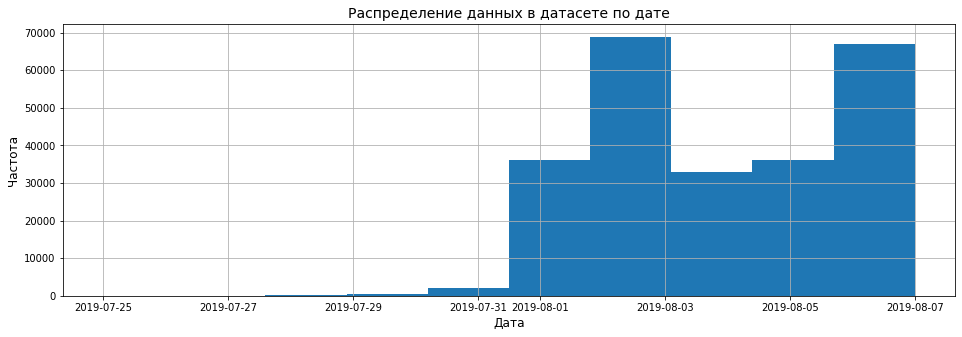

In [16]:
data['date'].hist(figsize=(16, 5));
plt.title('Распределение данных в датасете по дате', fontsize=14);
plt.xlabel('Дата', fontsize=12);
plt.ylabel('Частота', fontsize=12);

Из гистограммы выше мы видим, что данные у нас неравномерно распределены во времени. До 31 июля данных очень мало. Так как технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого, для анализа возьмём данные с 1 по 7 августа.

Посчитаем сколько событий и пользователей мы потеряем, если отбросим  данные с 25 по 31 июля.

In [17]:
round(len(data.query('date < "2019-08-01"'))/len(data), 4)

0.0116

In [18]:
round(1-(data.query('date >= "2019-08-01"')['user_id'].nunique()/data['user_id'].nunique()), 4)

0.0023

Отбросив старые данные, мы потеряем 1,16% всех событий и  0,23% уникальных пользователей.

In [19]:
data = data.query('date >= "2019-08-01"')

Теперь проверим, что в нашей выборке есть пользователи из всех трёх экспериментальных групп.

In [20]:
data.groupby('exp_id').agg({'user_id':'nunique'}).reset_index()

,exp_id,user_id
0,246,2484
1,247,2513
2,248,2537


 Из таблицы выше мы видим, что пользователи равномерно распределены между тремя экспериментальными группами.

**Вывод**

На данном этапе мы изучили данные в нашем датасете. В среднем на одного пользователя приходится 32 события. Мы располагаем записями логов  с 25 июля по 7 августа 2019 года. Так как данные распределены неравномерно, мы отбросили данные с 25 по 31 июля и убедились, что потеряли незначительное количество данных (1,16% всех событий и 0,23% уникальных пользователей). Также мы провеорили, что пользователи равномерно распределены между тремя экспериментальными группами.

## Анализ воронки событий

Посмотрим, какие события есть в логах, и  как часто они встречаются.

In [21]:
data['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Чаще всего пользователи открывают главную страницу, что вполне логично, оно появляется при открытии приложения. Такое действие за неделю пользователи совершали 117 328 раз. Затем идёт просмотр предложений с товарами и корзина. Здесь число событий очень похоже (46 333 и 42 303). Ещё меньше пользователей переходят к оплате покупок (33 918 событий за неделю). Реже всего пользователи заходят на страницу с обучающими материалами (1005).

Теперь найдём количество пользователей, которые совершали каждое из этих событий.

In [22]:
users_groupped = data.groupby('user_id').agg({'event_name':'nunique'}).reset_index()
users_groupped.columns = ['user_id', 'unique_events_count']

all_events_users = users_groupped.query('unique_events_count == 5')
len(all_events_users)

466

Всего 466 пользователей совершали каждое из событий. 

Отсортируем события по числу пользователей.

In [23]:
events_by_user = data.groupby('event_name').agg({'user_id':'nunique'}).reset_index()
events_by_user.columns = ['event_name', 'count']
events_by_user = events_by_user.sort_values(by='count', ascending = False)
events_by_user

,event_name,count
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Также как и при расчёте числа событий, пользователи чаще всего заходят на главную страницу,и реже всего на страницу с тьюториалом.

Добавим столбец с долей пользователей, которые хотя бы раз совершали то или иное событие.

In [24]:
events_by_user['share'] = round(events_by_user['count'] / data['user_id'].nunique(), 2)
events_by_user

,event_name,count,share
1,MainScreenAppear,7419,0.98
2,OffersScreenAppear,4593,0.61
0,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47
4,Tutorial,840,0.11


Практически все пользователи (98%) открывали главную страницу, 61% просматривали предложения товаров в магазине, ровно половина переходила к корзине и почти столько же, 47% оплачивали покупку. На страницу c обучающими материалами заходило 11% пользователей.

Вероятно в таком порядке и происходят события:

1. Пользователь открывает приложение (главная страница)
2. Просматривает предложения товаров в магазине
3. Добавляет товары в корзину
4. Оплачивает покупку

В какой момент пользователь открывает тьюториал предположить достаточно сложно, его просматривает небольшое количество пользователей. Можно предположить, что только новые пользователи после главной страницы смотрят тьюториал, а потом начинают просматривать товары. С другой стороны, возможно интерфейс в нашем приложении интуитивно-понятный пользователю и  дополнительно просматривать обучающие материалы  большинству не нужно. При дальнейшем построении воронки это событие использовать не будем.

In [25]:
purchase_funnel = events_by_user.drop(index=4)
purchase_funnel

,event_name,count,share
1,MainScreenAppear,7419,0.98
2,OffersScreenAppear,4593,0.61
0,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47


Добавим информацию какая  доля пользователей проходит на следующий шаг воронки.

In [26]:
purchase_funnel['ratio_to_previous_event'] = round(purchase_funnel['count']/purchase_funnel['count'].shift(1),2)
purchase_funnel

,event_name,count,share,ratio_to_previous_event
1,MainScreenAppear,7419,0.98,NaN
2,OffersScreenAppear,4593,0.61,0.62
0,CartScreenAppear,3734,0.50,0.81
3,PaymentScreenSuccessful,3539,0.47,0.95


In [49]:
fig = go.Figure(
    go.Funnel(
        y=[
            'Открыли главную страницу',
            'Просматривали предложения товаров',
            'Перешли в корзину',
            'Оплатили заказ',
        ],
        x=purchase_funnel['count'],
        )
)
fig.update_layout(title="Воронка событий в приложении")

fig.show() 

Больше всего пользователей теряется на этапе перехода с главной страницы к просмотру предложений товаров, остаётся только 62% пользователей. Возможно в этой части стоит поправить интерфейс, чтобы пользователи активнее проходили дальше. Если пользователь открыл приложение то логично, что он как минимум заинтересован посмотреть какие продукты и цены мы предлагаем.

Посчитаем какая доля пользователей доходит от первого события до оплаты.

In [28]:
round(3539/7419,2)

0.48

**Вывод**

На данном этапе мы проанализировали воронку продаж. Практически все пользователи 98% открывали главную страницу, 62% просматривали предложения товаров в магазине, ровно половина переходила к корзине и почти столько же оплачивали покупку. На страницу c обучающими материалами заходило всего 11% пользователей, поэтому это событие мы не учитывали при расчёте воронки. Всего 466 пользователей совершали каждое из событий. Больше всего пользователей теряется на этапе перехода с главной страницы к просмотру предложений товаров, остаётся только 62% пользователей. При этом 48% пользователей доходят до оплаты, это очень высокий показатель.

## Анализ результатов A/A/В теста

Посмотрим сколько пользователей в каждой экспериментальной группе.

In [29]:
data.groupby('exp_id').agg({'user_id':'nunique'}).reset_index()

,exp_id,user_id
0,246,2484
1,247,2513
2,248,2537


Количество пользователей в каждой группе практически равно. Убедимся, что пользователи попали только в одну экспериментальную группу.

In [30]:
users_by_exp_id = data.groupby('user_id').agg({'exp_id':'nunique'})
users_by_exp_id['exp_id'].value_counts()

1    7534
Name: exp_id, dtype: int64

Деление по группам было проведено корректно, все пользователи находятся только в одной группе.

У нас есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов.  Проверим, находят ли статистические критерии разницу между выборками 246 и 247. Для этого проведём z-тест для проверки статистически значимых различий между группами.

In [31]:
# уберем данные по событию Tutorial
data_AB_test = data.query('event_name != "Tutorial"')

# создадим таблицу с количеством пользователей для каждого события из воронки в разрезе групп
data_by_exp = data_AB_test.pivot_table(index='event_name',
                                         columns = 'exp_id',
                                         values = 'user_id',
                                         aggfunc='nunique',
                                      ).sort_values(by=246, ascending=False)

#добавим столбец с суммой пользователей для групп из A/A теста, 246 и 247
data_by_exp['sum_246_247'] = data_by_exp[246]+data_by_exp[247]
data_by_exp

exp_id,246,247,248,sum_246_247
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


In [32]:
# cоздадим таблицу с количеством пользователей по группам
users_by_exp_id = data_AB_test.groupby('exp_id').agg({'user_id':'nunique'}).reset_index()
users_by_exp_id.loc[3] = ['sum_246_247', 4995]
users_by_exp_id = users_by_exp_id.set_index(users_by_exp_id.columns[0])
users_by_exp_id

,user_id
exp_id,
246,2483
247,2512
248,2535
sum_246_247,4995


Сформулируем нулевую и альтернативную гипотезы:

* H0: между группами нет значимой разница
* H1: между группами есть значимая разница

Для проверки гипотез примем пятипроцентный уровень значимости.

Создадим функцию, которая принимала бы номера групп для сравнения и уровень значимости, а  рассчитывала p-value по каждому из событий.

In [33]:
def ztest(group1, group2, event_name, alpha):
    
    p1=data_by_exp.loc[event_name, group1]/users_by_exp_id.loc[group1, 'user_id']
    p2=data_by_exp.loc[event_name, group2]/users_by_exp_id.loc[group2, 'user_id']
    p_combined = (data_by_exp.loc[event_name, group1] + data_by_exp.loc[event_name, group2]) / (users_by_exp_id.loc[group1, 'user_id'] + users_by_exp_id.loc[group2, 'user_id'])
    difference = p1 - p2
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/users_by_exp_id.loc[group1, 'user_id'] + 1/users_by_exp_id.loc[group2, 'user_id']))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Группы:  {} и {}\nCобытие: {}\np-value: {p_value:.3f}'.format(group1, group2, event_name, p_value=p_value))
    if (p_value < alpha):
        print('Отвергаем нулевую гипотезу: между группами есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными')
    

In [34]:
for event_name in data_by_exp.index:
    ztest(246, 247, event_name, 0.05)
    print()

Группы:  246 и 247
Cобытие: MainScreenAppear
p-value: 0.753
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Группы:  246 и 247
Cобытие: OffersScreenAppear
p-value: 0.248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Группы:  246 и 247
Cобытие: CartScreenAppear
p-value: 0.229
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Группы:  246 и 247
Cобытие: PaymentScreenSuccessful
p-value: 0.114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



Разницы между выборками 246 и 247 нет. Критерии успешного А/А теста соблюдены:

* Количество пользователей в  группах различается на 1%;
* Для всех групп фиксируют  данные об одном и том же;
* Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
* Попавший в одну из групп посетитель остаётся в этой группе до конца теста. 


Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию.

In [35]:
for event_name in data_by_exp.index:
    ztest(246, 248, event_name, 0.05)
    print()

Группы:  246 и 248
Cобытие: MainScreenAppear
p-value: 0.339
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Группы:  246 и 248
Cобытие: OffersScreenAppear
p-value: 0.214
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Группы:  246 и 248
Cобытие: CartScreenAppear
p-value: 0.081
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Группы:  246 и 248
Cобытие: PaymentScreenSuccessful
p-value: 0.217
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



In [36]:
for event_name in data_by_exp.index:
    ztest(247, 248, event_name, 0.05)
    print()

Группы:  247 и 248
Cобытие: MainScreenAppear
p-value: 0.519
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Группы:  247 и 248
Cобытие: OffersScreenAppear
p-value: 0.933
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Группы:  247 и 248
Cобытие: CartScreenAppear
p-value: 0.588
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Группы:  247 и 248
Cобытие: PaymentScreenSuccessful
p-value: 0.728
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



Оснований отвергнуть нулевую гипотезу об отсутствии разницы между группами у нас нет. Изменение шрифтов в приложении не повлияло на поведение пользователей.

Сравним результаты с объединённой контрольной группой. 

In [37]:
for event_name in data_by_exp.index:
    ztest('sum_246_247', 248, event_name, 0.05)
    print()

Группы:  sum_246_247 и 248
Cобытие: MainScreenAppear
p-value: 0.349
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Группы:  sum_246_247 и 248
Cобытие: OffersScreenAppear
p-value: 0.446
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Группы:  sum_246_247 и 248
Cобытие: CartScreenAppear
p-value: 0.187
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Группы:  sum_246_247 и 248
Cобытие: PaymentScreenSuccessful
p-value: 0.611
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



На 5% уровне значимости у нас снова нет оснований отвергнуть нулевую гипотез, изменение шрифта не повлияло на поведение пользователей.

Мы провели 4 А/А теста и 12 А/В тестов. Так как p-value у нас достаточно высокий при 10% уровне значимости мы также принимали бы нулевую гипотезу. Исключение в таком случае составило бы только сравнение групп 246 и 248 по событию "открытие корзины".

## Общий вывод

Мы проанализировали записи логов за период с 25 июля по 7 августа 2019. Исходный датасет был обработан: заменены названия столбцов, данные в столбце с датой события были приведены к корректному типу, дубликаты строк были удалены.
Поскольку данные были распределены во времени неравномерно, для дальнейшего анализа мы использовали только записи логов с 1 по 7 августа.

В результате анализа воронки событий были сделаны следующие выводы:
* В среднем на одного пользователя приходится 32 события.
* Только 466 пользователей из 7534 совершали все события.
* Практически все пользователи 98% открывали главную страницу, 61% просматривали предложения товаров в магазине, ровно половина переходила к корзине и почти столько же оплачивали покупку. На страницу c обучающими материалами заходило всего 11% пользователей, поэтому это событие мы не учитывали при расчёте воронки.
* Больше всего пользователей теряется на этапе перехода с главной страницы к просмотру предложений товаров, остаётся только 62% пользователей.
* 48% всех пользователей совершали покупку, что является очень высоким показателем.

Результаты A/A/B-теста свидетельствуют о том, что изменение шрифта не повлияет на поведение пользователей. В таком случае менять шрифты в приложении не стоит, если это потребует дополнительных затрат.